Training Accuracy : 0.736793327154773
Training Precision : 0.8732849071832123
 
Test Accuracy : 0.7479838709677419
Test Precision : 0.8258928571428571


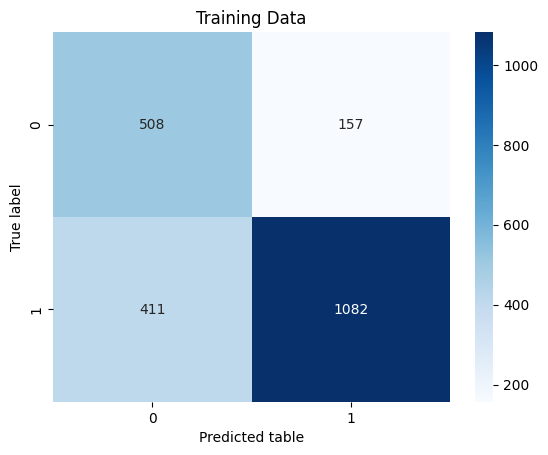

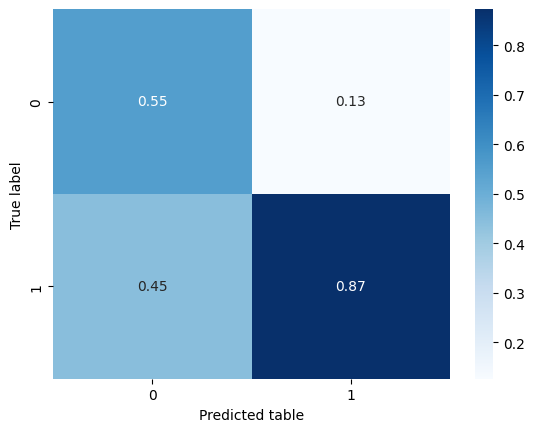

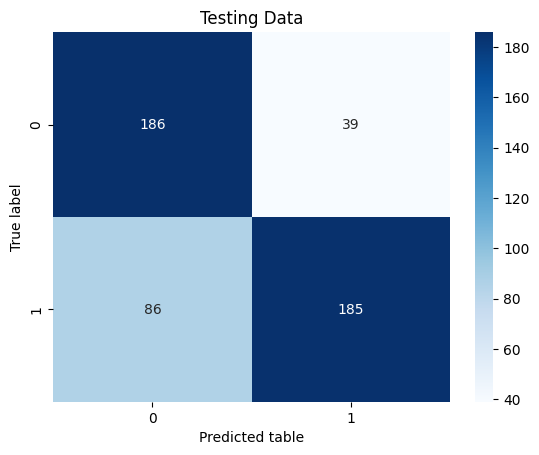

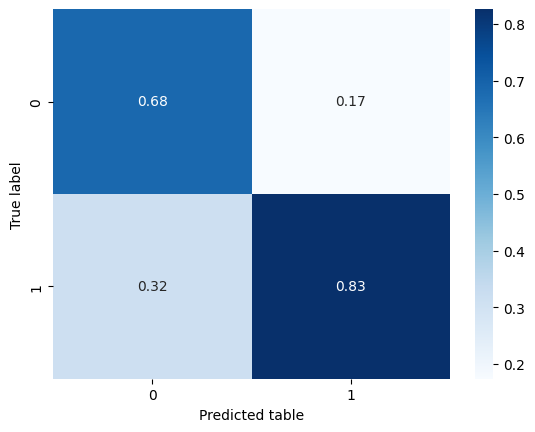

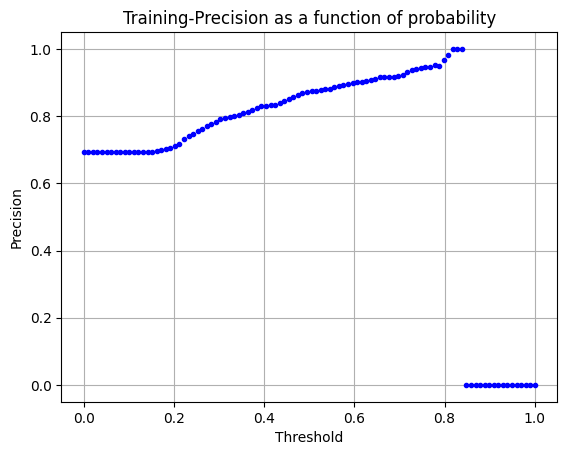

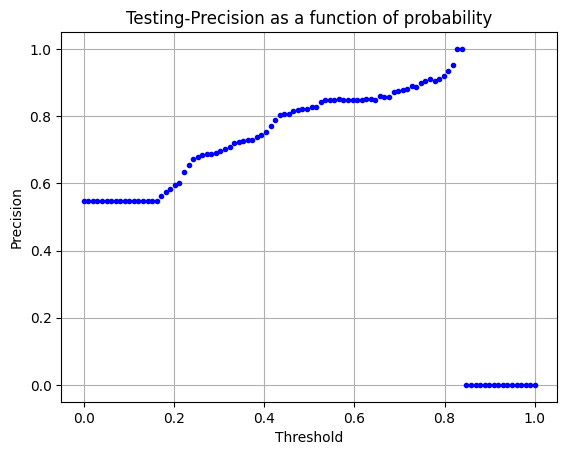

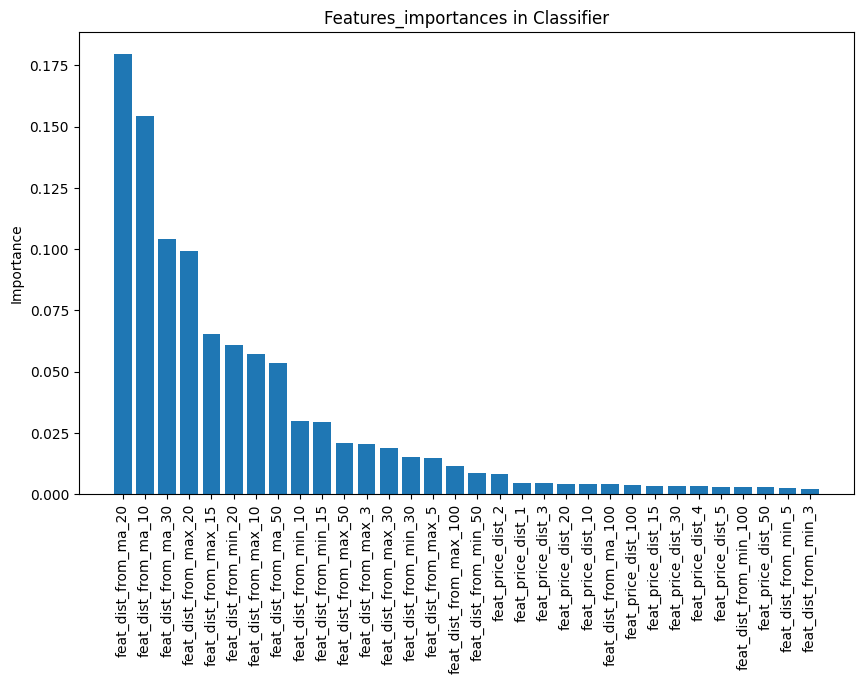

/usr/local/lib/python3.8/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

today=date.today()
d1=today.strftime("%Y-%m-%d")
end_date=d1
d2=date.today()-timedelta(days=4000)
d2=d2.strftime("%Y-%m-%d")
start_date=d2


df=yf.download('^SPX',start=start_date,end=end_date,progress= False).reset_index()


df.head()


# Distance from the moving averages
for m in [10,20,30,50,100]:
    df[f'feat_dist_from_ma_{m}']=df['Close']/df['Close'].rolling(m).mean()-1

# Distance from n day max/min
for m in [3,5,10,15,20,30,50,100]:
    df[f'feat_dist_from_max_{m}']=df['Close']/df['High'].rolling(m).max()-1
    df[f'feat_dist_from_min_{m}']=df['Close']/df['Low'].rolling(m).min()-1

# Price Distance
for m in [1,2,3,4,5,10,15,20,30,50,100]:
    df[f'feat_price_dist_{m}']=df['Close']/df['Close'].shift(m).mean()-1



df['target_ma']=df['Close'].rolling(20).mean()
df['Price_above_ma']=df['Close']>df['target_ma']
df['target']=df['Price_above_ma'].astype(int).shift(-5)

#Cleaning

df=df.dropna()



feat_cols=[col for col in df.columns if 'feat' in col]
train_until='2022-01-01'
x_train=df[df['Date']<train_until][feat_cols]
y_train=df[df['Date']<train_until]['target']
x_test=df[df['Date']>=train_until][feat_cols]
y_test=df[df['Date']>=train_until]['target']



from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score

clf= RandomForestClassifier(n_estimators=100,
max_depth=3,
random_state=42,
class_weight='balanced',)


clf.fit(x_train,y_train)


y_train_pred=clf.predict(x_train)
y_test_pred=clf.predict(x_test)



## Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train,y_train_pred)
train_precision = precision_score(y_train,y_train_pred)

## Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test,y_test_pred)
test_precision = precision_score(y_test,y_test_pred)


print(f'Training Accuracy : {train_accuracy}')
print(f'Training Precision : {train_precision}')
print(' ')
print(f'Test Accuracy : {test_accuracy}')
print(f'Test Precision : {test_precision}')


#Confusion Matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true,y_pred,title,normalize):
    if normalize:
        cm=confusion_matrix(y_true,y_pred,normalize='pred')
        sns.heatmap(cm,annot=True,fmt='.2f',cmap='Blues')
    else:
        cm=confusion_matrix(y_true,y_pred)
        sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
        plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted table')
    plt.show()
    return

plot_confusion_matrix(y_train,y_train_pred,title='Training Data',normalize=False)
plot_confusion_matrix(y_train,y_train_pred,title='Training Data-Normalized',normalize=True)
plot_confusion_matrix(y_test,y_test_pred,title='Testing Data',normalize=False)
plot_confusion_matrix(y_test,y_test_pred,title='Testing Data-Normalized',normalize=True)





## Precision Curve
def get_precision_curve(clf,x,y,title):
    y_score=clf.predict_proba(x)[:,1]
    thresholds=np.linspace(0,1,100)
    precision=[]
    for t in thresholds :
        y_pred_thresholds=(y_score>= t).astype(int)
        precision.append(precision_score(y,y_pred_thresholds,zero_division=0))
    plt.plot(thresholds,precision,'b.')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.show()
    return
get_precision_curve(clf,x_train,y_train,'Training-Precision as a function of probability')
get_precision_curve(clf,x_test,y_test,'Testing-Precision as a function of probability')


feature_importances=clf.feature_importances_
sorted_indices= feature_importances.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.title("Features_importances in Classifier")
plt.bar(range(x_train.shape[1]),feature_importances[sorted_indices],align='center')
plt.xticks(range(x_train.shape[1]),x_train.columns[sorted_indices],rotation=90)
plt.ylabel('Importance')
plt.show()



import plotly.graph_objects as go
df_test=df[df['Date']>=train_until].reset_index(drop=True)
df_test['pred_prob']=clf.predict_proba(x_test)[:,1]
df_test['pred']=df_test['pred_prob']>0.5
fig=go.Figure()

fig.add_trace(
go.Candlestick(x=df_test['Date'],
open=df_test['Open'],
high=df_test['High'],
low=df_test['Low'],
close=df_test['Close'],
showlegend=False,
)
)
fig.add_trace(
go.Line(x=df_test['Date'],
y=df_test[f'target_ma'],
name=f'Target SMA')
)
df_pattern=(df_test[df_test['pred']]
.groupby((~df_test['pred']).cumsum())
['Date']
.agg(['first','last'])
)
for idx, row in df_pattern.iterrows():
    fig.add_vrect(
    x0=row['first'],
    x1=row['last'],
    line_width=0, fillcolor='green',
    opacity=0.2,
    )
fig.update_layout(
xaxis_rangeslider_visible=False,
xaxis_title='Date',
yaxis_title='Price $',
title='Classified Results on SPX',
width=1000,
height=700,
)
fig.show()
